<a href="https://colab.research.google.com/github/BryanGuapulema/IMDB-movies-analysis/blob/main/IMDB_movies_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Preparación de data**

Objetivo:

*   Input (X): Comentarios
*   Output (Y): Sentimiento(Percepcion)






## 1.1. Lectura del dataset


In [24]:
import pandas as pd
df_review = pd.read_csv('./IMDB Dataset.csv')


In [16]:
df_review.shape

(50000, 2)

In [17]:
df_review.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 1.2.Desbalancear los datos

Se tomaron 9000 comentarios positivos y 1000 comentarios negativos para entrenar el modelo.

In [25]:
df_positive = df_review[df_review['sentiment'] == 'positive'][:9000]
df_negative = df_review[df_review['sentiment'] == 'negative'][:1000]

df_review_imb = pd.concat([df_positive, df_negative])
df_review_imb.value_counts('sentiment')

,count
sentiment,
positive,9000
negative,1000


##1.3 Balancear el dataset

Se usa la libreria imblearn para igualar el numero de casos para ambos sentimientos. Se opta por under_sampling para que los 9000 casos se reduzcan a la cantidad de casos más baja (1000)

In [28]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
df_review_bal, df_review_bal['sentiment'] = rus.fit_resample(df_review_imb[['review']], df_review_imb['sentiment'])

df_review_bal.value_counts('sentiment')

,count
sentiment,
negative,1000
positive,1000


## 1.4 Separar data de entrenameinto y de testing

Se usa la data balanceada y se separa en data de entrenamiento y testeo. En este caso se usa una proporción de 67% para entrenamiento y 33% para validación del modelo

In [32]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_review_bal['review'], df_review_bal['sentiment'], test_size=0.33, random_state=42)

In [35]:
print(x_train.shape, x_test.shape)

(1340,) (660,)


# 2. Representación de texto (BAG of words)



## 2.1. Transformación de datos de texto a valores numéricos.
Existen 2 alternativas:
* **CountVectorizer**: mide la frecuencia en que una palabra aparecer en una oración
* **Tfidf**: Mide la relevancia que tiene una palabra en una oración considerando que no se repite en otras oraciones del dataset ( es representativa ). Los numeros dados son en decimales de 0 a 1



In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
x_train_vector = tfidf.fit_transform(x_train)
x_test_vector = tfidf.transform(x_test)

In [38]:
x_train_vector

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 118047 stored elements and shape (1340, 20604)>

# 3. Modelos de Clasificación (Aprendizaje No Supervisado)

##3.1. Support Vector Machine (SVM)


In [39]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')
svc.fit(x_train_vector, y_train)

SVC(kernel='linear')

###3.1.1. Prueba del modelo

In [41]:
print(svc.predict(tfidf.transform(['This is a good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie. It was awful'])))


['positive']
['positive']
['negative']


In [42]:
print(svc.score(x_test_vector, y_test))

0.8196969696969697


##3.2. Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train_vector, y_train)

DecisionTreeClassifier()

3.2.1. Prueba del modelo

In [44]:
print(dtc.predict(tfidf.transform(['This is a good movie'])))
print(dtc.predict(tfidf.transform(['An excellent movie'])))
print(dtc.predict(tfidf.transform(['I did not like this movie. It was awful'])))
print(dtc.score(x_test_vector, y_test))

['positive']
['positive']
['negative']
0.6272727272727273


## 3.3.Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train_vector.toarray(), y_train)

GaussianNB()

###3.3.1. Prueba del modelo

In [50]:
print(gnb.predict(tfidf.transform(['This is a good movie']).toarray()))
print(gnb.predict(tfidf.transform(['An excellent movie']).toarray()))
print(gnb.predict(tfidf.transform(['I did not like this movie. It was awful']).toarray()))
print(gnb.score(x_test_vector.toarray(), y_test))

['negative']
['negative']
['negative']
0.6136363636363636


## 3.4 Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_vector, y_train)

LogisticRegression()

###3.4.1. Prueba del modelo

In [53]:
print(lr.predict(tfidf.transform(['This is a good movie'])))
print(lr.predict(tfidf.transform(['An excellent movie'])))
print(lr.predict(tfidf.transform(['I did not like this movie. It was awful'])))
print(lr.score(x_test_vector, y_test))

['negative']
['positive']
['negative']
0.8045454545454546


# 4. Evaluación del modelo

##4.1 Score del modelo (accuracy)

Se refiere a la precisión del modelo y no de las prediciones

In [55]:
print(svc.score(x_test_vector, y_test))
print(dtc.score(x_test_vector, y_test))
print(gnb.score(x_test_vector.toarray(), y_test))
print(lr.score(x_test_vector, y_test))


0.8196969696969697
0.6272727272727273
0.6136363636363636
0.8045454545454546


###4.2 F1 Score

F1 Score = 2*(Recall * Precision)/(Recall + Precision)

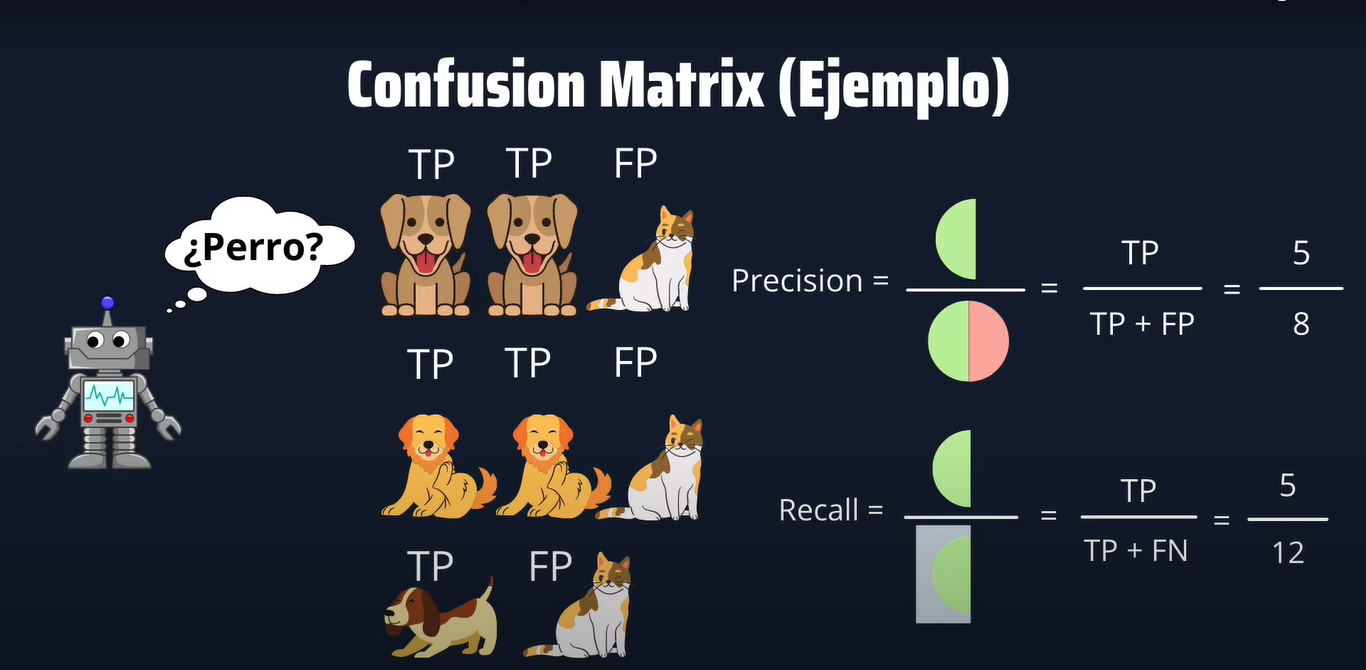

In [58]:
from sklearn.metrics import f1_score
print(f1_score(y_test, svc.predict(x_test_vector),
         labels = ['positive','negative'],
         average=None))
print(f1_score(y_test, dtc.predict(x_test_vector),
         labels = ['positive','negative'],
         average=None))
print(f1_score(y_test, gnb.predict(x_test_vector.toarray()),
         labels = ['positive','negative'],
         average=None))
print(f1_score(y_test, lr.predict(x_test_vector),
         labels = ['positive','negative'],
         average=None))

[0.82212257 0.8172043 ]
[0.625      0.62951807]
[0.64435146 0.57711443]
[0.80717489 0.80184332]


## 4.3 Reporte de Clasificación

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(x_test_vector),
         labels = ['positive','negative']))

              precision    recall  f1-score   support

    positive       0.82      0.82      0.82       335
    negative       0.82      0.82      0.82       325

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660



## 4.4. Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, svc.predict(x_test_vector),
         labels = ['positive','negative']))


[[275  60]
 [ 59 266]]


#5. Optmización del modelo

In [ ]:
###5.1 Grid Search CV

In [61]:
from sklearn.model_selection import GridSearchCV
params = {
    'C':[1,4,8,16,32], #error soportable
    'kernel':['linear','rbf'] #especifica el tipo de funcion a usar
}

svc = SVC()
svc_grid = GridSearchCV(svc,params, cv=5)
svc_grid.fit(x_train_vector,y_train)



GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 4, 8, 16, 32], 'kernel': ['linear', 'rbf']})

In [62]:
print(svc_grid.best_estimator_)
print(svc_grid.best_params_)
print(svc_grid.best_score_)


SVC(C=1, kernel='linear')
{'C': 1, 'kernel': 'linear'}
0.8335820895522389
